# CS 4964 - Final Project: Command Word Audio
<div style="text-align: right; font-weight: bold;"> Tyler DeBruin </div>
<div style="text-align: right; font-weight: bold;"> Nolan Angerbauer </div>
<br>
<div style="text-align: right; font-weight: bold;"> 3/28/2024 </div>
<br>


<div style="text-align: center; font-weight: bold;"> Final Project: Command Word Audio </div>

### Abstract

Utilizing Apache Spark, and a Command Word dataset provided by Huggingface.co we will build
and train a machine learning model that can differentiate command words from non-command words, or
silence and white noise. We provide a mechanism to forward audio into the model, and provide inference
on the output command word.


### Dataset
https://arxiv.org/abs/1804.03209

The dataset we will be using is from Huggingface.co. 

Repository: https://huggingface.co/datasets/speech_commands
<br>
As Per HuggingFace:
<br>
##### Language
English (BCP-47 en)
<br>
##### Collection
The audio files were collected using crowdsourcing. The goal was to gather examples of people speaking single-word commands, rather than conversational sentences, so they were prompted for individual words over the course of a five minute session. The dataset consists of people who have donated their voice online. 
<br><br>


In [1]:
import os
import numpy as np
import librosa
import soundfile
from speech_commands import SpeechCommands
from datasets import concatenate_datasets, load_dataset, load_from_disk
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BinaryType, Row, BooleanType
from pyspark.sql import SparkSession

from scipy.signal import wiener
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
spark = SparkSession.builder.master("local[1]") \
    .appName("Postgres") \
    .config("spark.jars", "/final/postgresql-42.7.3.jar") \
    .config("spark.sql.legacy.createHiveTableByDefault", "False") \
    .getOrCreate()

url = "jdbc:postgresql://postgres:5432/cs4964"

properties = {
    "user": "root",
    "password": "password",
    "driver": "org.postgresql.Driver"
}

In [4]:
dataset = load_dataset("speech_commands", "v0.02", keep_in_memory=False, num_proc=2)
dataset.save_to_disk("speechCommands")
dataset = load_from_disk("speechCommands")
dataset = dataset.with_format("torch")

Saving the dataset (0/6 shards):   0%|          | 0/84848 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9982 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4890 [00:00<?, ? examples/s]

In [5]:
training = dataset['train']
validation = dataset['validation']
combinedDataset = concatenate_datasets([training, validation])

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 84848
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 9982
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 4890
    })
})

In [7]:
training[0]

{'file': 'backward/2356b88d_nohash_0.wav',
 'audio': {'path': '2356b88d_nohash_0.wav',
  'array': tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0001, -0.0002, -0.0001]),
  'sampling_rate': tensor(16000)},
 'label': tensor(30),
 'is_unknown': tensor(True),
 'speaker_id': '2356b88d',
 'utterance_id': tensor(0)}

https://huggingface.co/docs/datasets/en/package_reference/main_classes

In [8]:
"""
fileId = 0
batched = 0
audio_rows = []
command_rows = []
for batch_idx, data in enumerate(dataloader):
    print(data)
    fileId += 1
    batched += 1
    # Process each item in the batch
    command_rows.append(Row(
        fileId=fileId,
        file=data['file'][0],
        label=data['label'].item(),
        is_unknown=data['is_unknown'].item(),
        speaker_id=data['speaker_id'][0],
        utterance_id=data['utterance_id'].item(),
    ))

    audio_rows.append(Row(
        fileid=fileId,
        Audio=np.array(data['audio']['array'][0], dtype=np.int16).tobytes(),
        SamplingRate=data['audio']['sampling_rate'].item()
    ))
    
    # Create DataFrames from the lists of rows

    # Write to PostgreSQL
    if(batched % 100 == 0):

        CommandWords_DF = spark.createDataFrame(command_rows, StructType([
            StructField("fileId", IntegerType(), False),
            StructField("file", StringType(), False),
            StructField("label", IntegerType(), False),
            StructField("is_unknown", BooleanType(), False),
            StructField("speaker_id", StringType(), False),
            StructField("utterance_id", IntegerType(), False)
        ]))
    
        Audio_DF = spark.createDataFrame(audio_rows, StructType([
            StructField("fileid", IntegerType(), False),
            StructField("Audio", BinaryType(), False),
            StructField("SamplingRate", IntegerType(), False),
        ]))


        CommandWords_DF.write.jdbc(url=url, table="AudioFile", mode="append", properties=properties)
        Audio_DF.write.jdbc(url=url, table="AudioBytes", mode="append", properties=properties)
        command_rows.clear()
        audio_rows.clear()
"""

'\nfileId = 0\nbatched = 0\naudio_rows = []\ncommand_rows = []\nfor batch_idx, data in enumerate(dataloader):\n    print(data)\n    fileId += 1\n    batched += 1\n    # Process each item in the batch\n    command_rows.append(Row(\n        fileId=fileId,\n        file=data[\'file\'][0],\n        label=data[\'label\'].item(),\n        is_unknown=data[\'is_unknown\'].item(),\n        speaker_id=data[\'speaker_id\'][0],\n        utterance_id=data[\'utterance_id\'].item(),\n    ))\n\n    audio_rows.append(Row(\n        fileid=fileId,\n        Audio=np.array(data[\'audio\'][\'array\'][0], dtype=np.int16).tobytes(),\n        SamplingRate=data[\'audio\'][\'sampling_rate\'].item()\n    ))\n    \n    # Create DataFrames from the lists of rows\n\n    # Write to PostgreSQL\n    if(batched % 100 == 0):\n\n        CommandWords_DF = spark.createDataFrame(command_rows, StructType([\n            StructField("fileId", IntegerType(), False),\n            StructField("file", StringType(), False),\n       

### Preprocessing

To begin curating the data, we start by finding all data points outside of 16kHz, and resampling those.
That includes both upsampling, and downsampling any audio files.

Arrange: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
Interp: https://numpy.org/doc/stable/reference/generated/numpy.interp.html


##### MelSpectrogram

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

In [9]:
import torchaudio.transforms as T

def preprocess_audio(row):

    #[channel, time]
    #All of our audio files are expected to be [1, 16000]
    waveform = row['audio']['array'].unsqueeze(0)
    
    sampleRate = row['audio']['sampling_rate']
    
    #DENOISING
    denoisedWaveform = torch.from_numpy(wiener(waveform.squeeze().numpy(), mysize=1024)).to(torch.float32).unsqueeze(0)
    
    melSpectrogramTransformer = T.MelSpectrogram(
        sample_rate=sampleRate,
        n_fft=1024,
        hop_length=516,
        n_mels=64
    )
    
    melSpectrogram = melSpectrogramTransformer(waveform)
    
    #print('melSpectrogram', melSpectrogram.shape, 'melSpectrogramDenoised', melSpectrogramDenoised.shape, 'melSpectrogram.size(1)', melSpectrogram.size(1))
    #Pad all of the Spectograms to 32
    if melSpectrogram.size(2) < 32:
        # Pad the spectrogram
        pad_amount = 32 - melSpectrogram.size(2)
        melSpectrogram = F.pad(melSpectrogram, (0, pad_amount))
    elif melSpectrogram.size(2) > 32:
        # Truncate the spectrogram
        melSpectrogram = melSpectrogram[:, :, :32]

    melSpectrogramDenoised = melSpectrogramTransformer(denoisedWaveform)

    if melSpectrogramDenoised.size(2) < 32:
        # Pad the spectrogram
        pad_amount = 32 - melSpectrogramDenoised.size(2)
        melSpectrogramDenoised = F.pad(melSpectrogramDenoised, (0, pad_amount))
    elif melSpectrogramDenoised.size(2) > 32:
        # Truncate the spectrogram
        melSpectrogramDenoised = melSpectrogramDenoised[:, :, :32]
    
    amplitudeToDB = T.AmplitudeToDB()

    result = {'spectrogram': amplitudeToDB(melSpectrogram).squeeze(0), 'spectrogramDenoised': amplitudeToDB(melSpectrogramDenoised).squeeze(0), 'label': row['label'] }

    return result

In [10]:
feature_Dataset = dataset.map(preprocess_audio)

Parameter 'function'=<function preprocess_audio at 0x7fc32d6ac540> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/84848 [00:00<?, ? examples/s]

Map:   0%|          | 0/9982 [00:00<?, ? examples/s]

Map:   0%|          | 0/4890 [00:00<?, ? examples/s]

In [11]:
def collate(batch):
    spectrograms = torch.stack([item['spectrogram'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return spectrograms, labels

In [12]:
train_DataLoader = DataLoader(feature_Dataset['train'], batch_size=64, shuffle=True, collate_fn=collate)
test_DataLoader = DataLoader(feature_Dataset['test'], batch_size=64, shuffle=True, collate_fn=collate)
validation_DataLoader = DataLoader(feature_Dataset['validation'], batch_size=64, shuffle=True, collate_fn=collate)

In [13]:
def collateDenoised(batch):
    spectrograms = torch.stack([item['spectrogramDenoised'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return spectrograms, labels

In [14]:
train_DataLoaderDenoised = DataLoader(feature_Dataset['train'], batch_size=32, shuffle=True, collate_fn=collateDenoised)
test_DataLoaderDenoised = DataLoader(feature_Dataset['test'], batch_size=32, shuffle=True, collate_fn=collateDenoised)
validation_DataLoaderDenoised = DataLoader(feature_Dataset['validation'], batch_size=32, shuffle=True, collate_fn=collateDenoised)

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

In [15]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


spectrograms.shape torch.Size([64, 64, 32])
torch.Size([64])


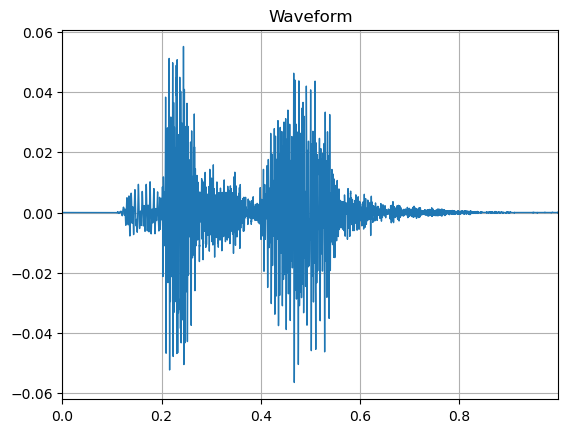

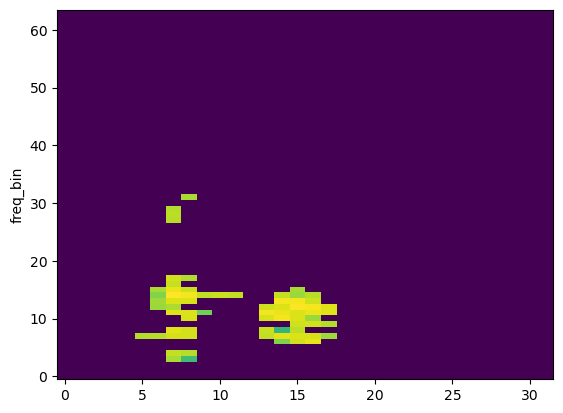

In [16]:
waveForm = feature_Dataset['train'][0]['audio']['array'].unsqueeze(0)
plot_waveform(waveForm, feature_Dataset['train'][0]['audio']['sampling_rate'])
plot_spectrogram(preprocess_audio(feature_Dataset['train'][0])['spectrogram'])

for spectrograms, labels in train_DataLoader:
    print('spectrograms.shape', spectrograms.shape)
    #print('spectrograms', spectrograms) 
    print(labels.shape)
    break

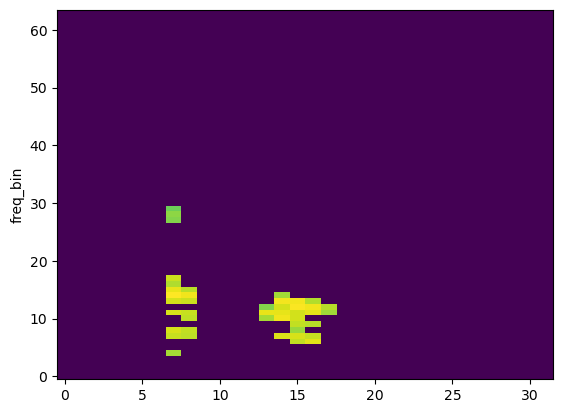

In [17]:
plot_spectrogram(preprocess_audio(feature_Dataset['train'][0])['spectrogramDenoised'])

### Convolution Neural Network
https://en.wikipedia.org/wiki/Convolutional_neural_network

In [18]:
torch.manual_seed(69)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(69)
    torch.cuda.manual_seed_all(69)
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

class CommandWordCNN(nn.Module):
    def __init__(self):
        super(CommandWordCNN, self).__init__()
        self.numberOfClasses = 36  # Number of classes
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Only 1 input channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Assuming input spectrograms are 64x32 after pooling and convolution it becomes 16x8
        self.fc1 = nn.Linear(32 * 16 * 8, 128)
        self.fc2 = nn.Linear(128, self.numberOfClasses)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA not available. Using CPU.


commandWord = CommandWordCNN()

crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(commandWord.parameters(), lr=0.001)

epochs = 4

# Training loop
for epoch in range(epochs): 

    for i, (spectogram, labels) in enumerate(train_DataLoader):
        
        #print(spectogram.unsqueeze(1).shape)
        optimizer.zero_grad()
        
        outputs = commandWord(spectogram.unsqueeze(1))
        
        loss = crossEntropyLoss(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        if i % 100 == 0:
            val, predicted = torch.max(outputs, 1)  
            total = labels.size(0)  
            correct = (predicted == labels).sum().item() 
            accuracy = 100 * correct / total 

            print(f'Epoch [{epoch + 1}], Step [{i}], Loss: {loss.item()}, Accuracy: {accuracy}')


        # Validation phase
    commandWord.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients for validation
        for spectrogram, labels in validation_DataLoader:
            spectrogram = spectrogram.unsqueeze(1)
            outputs = commandWord(spectrogram)
            val, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    commandWord.train()
    
    accuracy = 100 * correct / total
    print(f'Validation Accuracy after Epoch {epoch + 1}: {accuracy:.2f}%')

In [ ]:
commandWord = CommandWordCNN()

crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(commandWord.parameters(), lr=0.001)

epochs = 30

# Training loop
for epoch in range(epochs): 

    for i, (spectogram, labels) in enumerate(train_DataLoaderDenoised):
        
        #print(spectogram.unsqueeze(1).shape)
        optimizer.zero_grad()
        
        outputs = commandWord(spectogram.unsqueeze(1))
        
        loss = crossEntropyLoss(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        if i % 100 == 0:
            val, predicted = torch.max(outputs, 1)  
            total = labels.size(0)  
            correct = (predicted == labels).sum().item() 
            accuracy = 100 * correct / total 

            print(f'Epoch [{epoch + 1}], Step [{i}], Loss: {loss.item()}, Accuracy: {accuracy}')


        # Validation phase
    commandWord.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients for validation
        for spectrogram, labels in validation_DataLoaderDenoised:
            spectrogram = spectrogram.unsqueeze(1)
            outputs = commandWord(spectrogram)
            val, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    commandWord.train()
    
    accuracy = 100 * correct / total
    print(f'Validation Accuracy after Epoch {epoch + 1}: {accuracy:.2f}%')

Epoch [1], Step [0], Loss: 5.662467956542969, Accuracy: 6.25
Epoch [1], Step [100], Loss: 3.5086402893066406, Accuracy: 9.375
Epoch [1], Step [200], Loss: 2.69227933883667, Accuracy: 21.875
Epoch [1], Step [300], Loss: 2.5205817222595215, Accuracy: 25.0
Epoch [1], Step [400], Loss: 2.336198568344116, Accuracy: 31.25
Epoch [1], Step [500], Loss: 1.9495830535888672, Accuracy: 40.625
Epoch [1], Step [600], Loss: 1.6355581283569336, Accuracy: 43.75
Epoch [1], Step [700], Loss: 1.6794973611831665, Accuracy: 62.5
Epoch [1], Step [800], Loss: 1.5861510038375854, Accuracy: 50.0
Epoch [1], Step [900], Loss: 1.0663032531738281, Accuracy: 65.625
Epoch [1], Step [1000], Loss: 0.7390356063842773, Accuracy: 78.125
Epoch [1], Step [1100], Loss: 0.7850967645645142, Accuracy: 75.0
Epoch [1], Step [1200], Loss: 0.8324908018112183, Accuracy: 75.0
Epoch [1], Step [1300], Loss: 0.9000792503356934, Accuracy: 81.25
Epoch [1], Step [1400], Loss: 0.8829500079154968, Accuracy: 78.125
Epoch [1], Step [1500], Los

In [ ]:

for i, (spectogram, labels) in enumerate(test_DataLoader):



In [ ]:
!nvidia-smi